In [1]:
import torchvision.utils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import models as torch_models

from modules import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [4]:
imgnet_dataset = image_folder_dataset(root = 'data/imagenette2/train/', transform = transform, idx2label = idx2label)
imgnet_dataloader = DataLoader(imgnet_dataset, batch_size=1, shuffle=True)

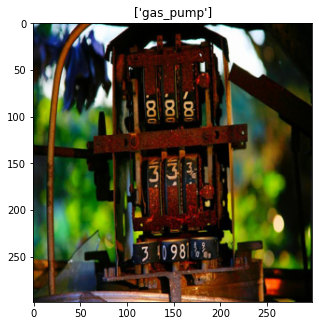

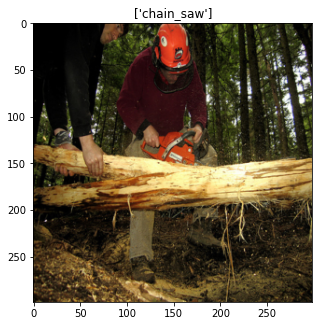

In [5]:
subset = get_list_from_dataloader(imgnet_dataloader,len = 2)
for item in subset:
    images, labels = item
    imshow(torchvision.utils.make_grid(images, normalize=True), [idx2label[x] for x in labels])

In [6]:
model = torch_models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


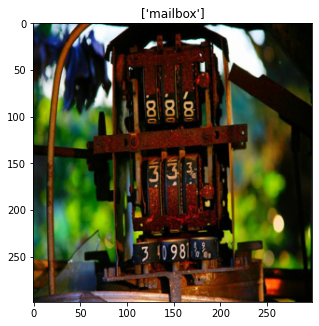

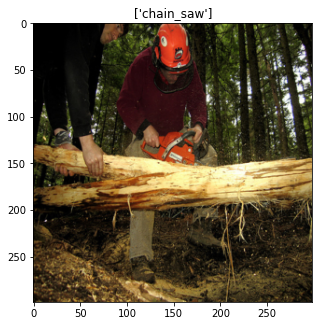


Accuracy of test text: 50.000000 %


In [7]:
eval(
    model=model,
    viz=True,
    dataset=subset,
    loader=subset,
    verbose=True,
)

In [ ]:
eval(
    model=model,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader,
    verbose=True,
)

Attack Image & Predicted Label


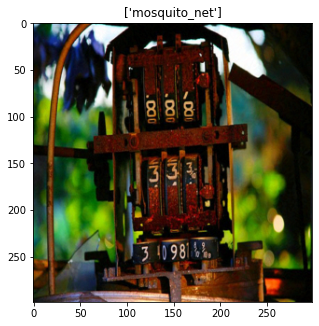

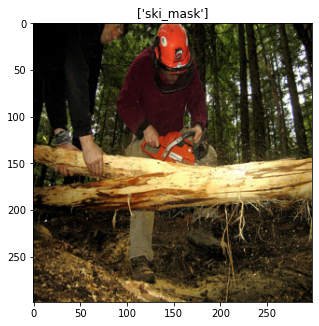


Accuracy of test text: 0.000000 %
Avg attack time is: 1.000000 


In [8]:
attack(
    model=model,
    viz=True,
    dataset=subset,
    loader=subset,
    verbose=True,
)

In [ ]:
attack(
    model=model,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader,
    verbose=True,
)

